# G-ring Velocity Dispersion Curve Computation Test

This notebook tests the G-ring velocity dispersion curve computation with interactive visualization and debugging capabilities.


In [1]:
# Import required libraries
import os
import gc
import sys
import yaml
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime, timedelta
from obspy import UTCDateTime
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Add the parent directory to the path to import sixdegrees
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..'))
from sixdegrees.sixdegrees import sixdegrees
from sixdegrees.plots.plot_backazimuth_results import plot_backazimuth_results
from sixdegrees.plots.plot_velocities import plot_velocities

# Set up plotting
plt.ion()  # Interactive mode
%matplotlib inline


## Configuration and Setup


In [2]:
# Load configuration
config_file = "config_gring_velocity.yml"
with open(config_file, 'r') as f:
    config = yaml.safe_load(f)

print("Configuration loaded:")
for key, value in config.items():
    print(f"  {key}: {value}")


Configuration loaded:
  data_source: fdsn
  fdsn_client_rot: LMU
  fdsn_client_tra: BGR
  seed: XX.RLAS..
  rot_seed: ['BW.RLAS..BJZ']
  tra_seed: ['GR.WET..BHZ', 'GR.WET..BHN', 'GR.WET..BHE']
  rot_remove_response: True
  tra_remove_response: True
  freq_min: 0.08
  freq_max: 0.5
  octave_fraction: 3
  wave_type: love
  baz_mode: max
  t_win_factor: 4.0
  overlap: 0.5
  cc_threshold: 0.75
  method: theilsen
  r_squared_threshold: 0.5
  Nprocesses: 4
  verbose: True
  output_dir: ./output
  log_dir: ./logs
  plot_dispersion: True


In [3]:
# Set up test parameters
start_time = UTCDateTime("2023-09-08T22:45:00")
end_time = start_time + 1800  # 1 hour for testing

print(f"Test period: {start_time} to {end_time}")
print(f"Duration: {(end_time - start_time) / 3600:.1f} hours")


Test period: 2023-09-08T22:45:00.000000Z to 2023-09-08T23:15:00.000000Z
Duration: 0.5 hours


## Data Loading and Validation


In [4]:
# Initialize sixdegrees object
config['tbeg'] = start_time
config['tend'] = end_time
sd = sixdegrees(config)

print("Sixdegrees object created")


Sixdegrees object created


In [ ]:
# Load data
print("Loading data...")
sd.load_data(start_time, end_time)
sd.trim_stream()

print(f"Loaded {len(sd.st)} traces")
for trace in sd.st:
    print(f"  {trace.id}: {trace.stats.starttime} - {trace.stats.endtime}")


Loading data...
-> fetching GR.WET..BHZ data from FDSN
-> fetching GR.WET..BHN data from FDSN
-> fetching GR.WET..BHE data from FDSN
-> translation inventory requested: Inventory created at 2025-09-19T00:23:02.752912Z
	Sending institution: SeisComP (BGR)
	Contains:
		Networks (1):
			GR
		Stations (1):
			GR.WET (GRSN Station Wettzell)
		Channels (9):
			GR.WET..BHZ, GR.WET..BHN, GR.WET..BHE, GR.WET..HHZ, GR.WET..HHN, 
			GR.WET..HHE, GR.WET..LHZ, GR.WET..LHN, GR.WET..LHE
-> removing response: ACC
3 Trace(s) in Stream:
GR.WET..BHZ | 2023-09-08T22:44:59.025000Z - 2023-09-08T23:15:00.975000Z | 20.0 Hz, 36040 samples
GR.WET..BHN | 2023-09-08T22:44:59.025000Z - 2023-09-08T23:15:00.975000Z | 20.0 Hz, 36040 samples
GR.WET..BHE | 2023-09-08T22:44:59.025000Z - 2023-09-08T23:15:00.975000Z | 20.0 Hz, 36040 samples
-> fetching BW.RLAS..BJZ data from FDSN


In [ ]:
# Check rotation and translation streams
try:
    rot_stream = sd.get_stream("rotation", raw=True)
    print(f"Rotation stream: {len(rot_stream)} traces")
    for trace in rot_stream:
        print(f"  {trace.id}: {trace.stats.starttime} - {trace.stats.endtime}")
except Exception as e:
    print(f"Error getting rotation stream: {e}")

try:
    tra_stream = sd.get_stream("translation", raw=True)
    print(f"Translation stream: {len(tra_stream)} traces")
    for trace in tra_stream:
        print(f"  {trace.id}: {trace.stats.starttime} - {trace.stats.endtime}")
except Exception as e:
    print(f"Error getting translation stream: {e}")


Rotation stream: 1 traces
  XX.RLAS..BJZ: 2023-09-08T22:44:58.977250Z - 2023-09-08T23:15:00.927250Z
Translation stream: 3 traces
  XX.RLAS..BHZ: 2023-09-08T22:44:59.025000Z - 2023-09-08T23:15:00.975000Z
  XX.RLAS..BHN: 2023-09-08T22:44:59.025000Z - 2023-09-08T23:15:00.975000Z
  XX.RLAS..BHE: 2023-09-08T22:44:59.025000Z - 2023-09-08T23:15:00.975000Z


## Frequency Band Generation


In [ ]:
# Generate frequency bands
flower, fupper, fcenter = sd.get_octave_bands(
    fmin=config.get('freq_min', 0.1),
    fmax=config.get('freq_max', 2.0),
    faction_of_octave=config.get('octave_fraction', 3)
)

print(f"Generated {len(fcenter)} frequency bands")
for i, (fmin, fmax, fc) in enumerate(zip(flower, fupper, fcenter)):
    print(f"  Band {i+1}: {fmin:.3f} - {fmax:.3f} Hz (center: {fc:.3f} Hz)")


Generated 9 frequency bands
  Band 1: 0.071 - 0.089 Hz (center: 0.079 Hz)
  Band 2: 0.089 - 0.112 Hz (center: 0.100 Hz)
  Band 3: 0.112 - 0.141 Hz (center: 0.126 Hz)
  Band 4: 0.141 - 0.178 Hz (center: 0.158 Hz)
  Band 5: 0.178 - 0.224 Hz (center: 0.200 Hz)
  Band 6: 0.224 - 0.282 Hz (center: 0.251 Hz)
  Band 7: 0.282 - 0.355 Hz (center: 0.316 Hz)
  Band 8: 0.355 - 0.447 Hz (center: 0.398 Hz)
  Band 9: 0.447 - 0.562 Hz (center: 0.501 Hz)


## Helper Functions


In [ ]:
from sixdegrees.utils.get_kde_stats_velocity import get_kde_stats_velocity

In [ ]:
def process_frequency_band(sd_hour, config, fmin, fmax, fcenter, hour_beg, hour_end):
    """
    Process a single frequency band for velocity computation.
    """
    try:
        # Filter data for this frequency band
        sd_filtered = sd_hour.copy()
        sd_filtered.filter_data(fmin=fmin, fmax=fmax)
        sd_filtered.trim(hour_beg, hour_end)
        
        if not sd_filtered.st or len(sd_filtered.st) == 0:
            return None
        
        # Check if we have both rotation and translation data
        try:
            rot_stream = sd_filtered.get_stream("rotation", raw=True)
            tra_stream = sd_filtered.get_stream("translation", raw=True)
            if not rot_stream or len(rot_stream) == 0 or not tra_stream or len(tra_stream) == 0:
                return None
        except Exception:
            return None
        
        # Calculate window length
        t_win_factor = config.get('t_win_factor', 2.0)
        win_time_s = int(t_win_factor / fcenter)
        
        # Compute backazimuths
        baz_results = sd_filtered.compute_backazimuth(
            wave_type=config.get('wave_type', 'love'),
            baz_step=1,
            baz_win_sec=win_time_s,
            baz_win_overlap=config.get('overlap', 0.5),
            verbose=False,
            out=True
        )
        
        if baz_results is None:
            return None
        
        # Plot backazimuth results
        try:
            fig = plot_backazimuth_results(
                sd_filtered, 
                baz_results,
                baz_theo=300,
                cc_threshold=config.get('cc_threshold', 0.0),
                cc_method=config.get('baz_mode', 'mid')
            )
            plt.title(f'Backazimuth Results - {fcenter:.3f} Hz')
            plt.show()
        except Exception as e:
            print(f"Error plotting backazimuths: {e}")
        
        # Compute velocities
        vel_results = sd_filtered.compute_velocities_optimized(
            rotation_data=sd_filtered.get_stream("rotation", raw=True),
            translation_data=sd_filtered.get_stream("translation", raw=True),
            wave_type=config.get('wave_type', 'love'),
            baz_results=baz_results,
            baz_mode=config.get('baz_mode', 'mid'),
            method=config.get('method', 'theilsen'),
            cc_threshold=config.get('cc_threshold', 0.0),
            r_squared_threshold=config.get('r_squared_threshold', 0.0),
            zero_intercept=False
        )
        
        if vel_results is None:
            return None
        
        # Plot velocity results
        try:
            vel_results['parameters']['baz'] = 300
            fig = plot_velocities(
                sd_filtered,
                velocity_results=vel_results,
                vmax=6000,
                minors=True,
                cc_threshold=config.get('cc_threshold', 0.0),
            )
            plt.title(f'Velocity Results - {fcenter:.3f} Hz')
            plt.show()
        except Exception as e:
            print(f"Error plotting velocities: {e}")
        
        # Extract valid measurements
        mask = ~np.isnan(vel_results['velocity'])
        velocities = vel_results['velocity'][mask]
        cc_values = vel_results['ccoef'][mask]
        
        if len(velocities) < 5:
            return None
        
        # Apply KDE analysis
        try:
            out = get_kde_stats_velocity(velocities, cc_values, plot=True)
            vel_max = out['max']
            vel_dev = out['dev']
        except Exception as e:
            print(f"Error computing KDE statistics for velocity: {e}")
            vel_max = np.nan
            vel_dev = np.nan
        
        return {
            'fband': fcenter,
            'velocity': vel_max,
            'deviation': vel_dev,
            'n_measurements': len(velocities),
            'velocities': velocities,
            'cc_values': cc_values
        }
        
    except Exception as e:
        print(f"Error processing frequency band {fcenter:.3f} Hz: {e}")
        return None


## Process Single Hour


In [ ]:
# Process one hour of data
print("Processing one hour of data...")

# Make a copy of the sixdegrees object
sd_hour = sd.copy()
sd_hour.trim(start_time-100, end_time+100)  # Add padding

if not sd_hour or len(sd_hour.st) == 0:
    print("No data available")
else:
    print(f"Processing {len(sd_hour.st)} traces")


Processing one hour of data...
Processing 4 traces



--- Processing frequency band 1/9: 0.079 Hz (0.071 - 0.089 Hz)---


baz_max = 229, baz_std = 49


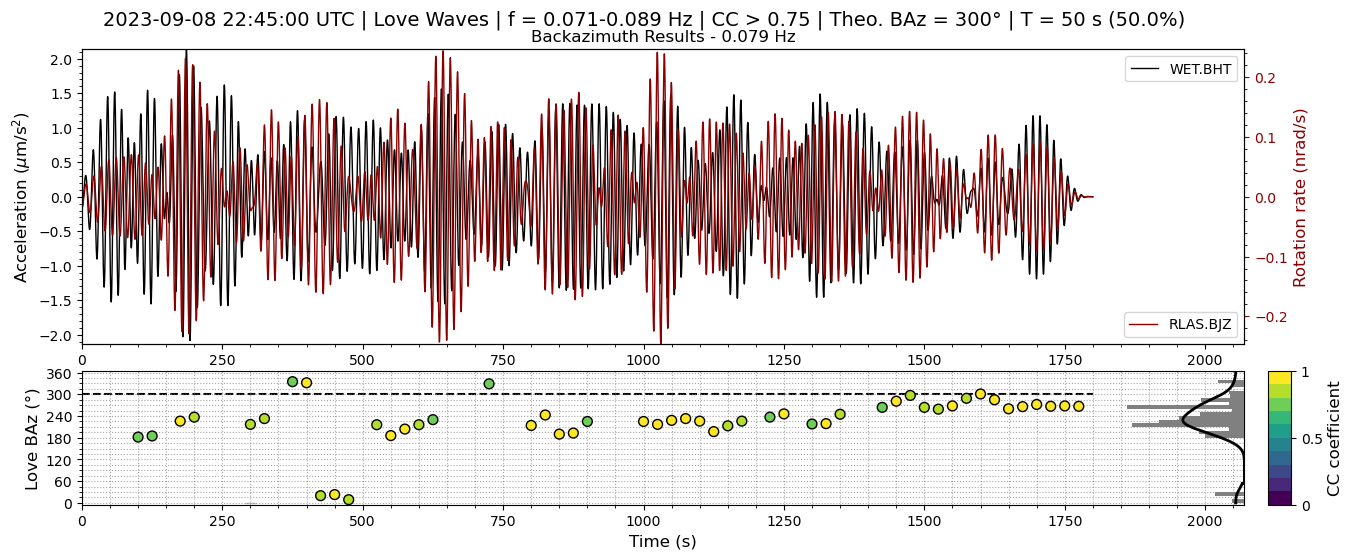

Error processing frequency band 0.079 Hz: Invalid method: theilsen. Use 'odr' or 'ransac'
  ✗ Failed

--- Processing frequency band 2/9: 0.100 Hz (0.089 - 0.112 Hz)---
baz_max = 246, baz_std = 61


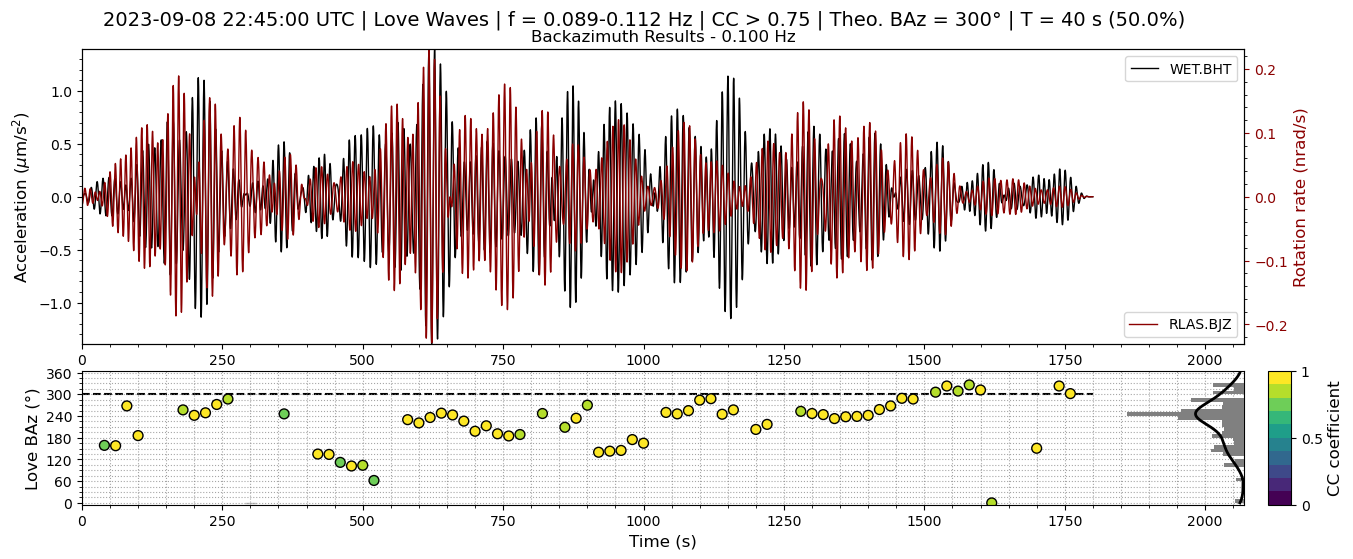

Error processing frequency band 0.100 Hz: Invalid method: theilsen. Use 'odr' or 'ransac'
  ✗ Failed

--- Processing frequency band 3/9: 0.126 Hz (0.112 - 0.141 Hz)---
baz_max = 247, baz_std = 63


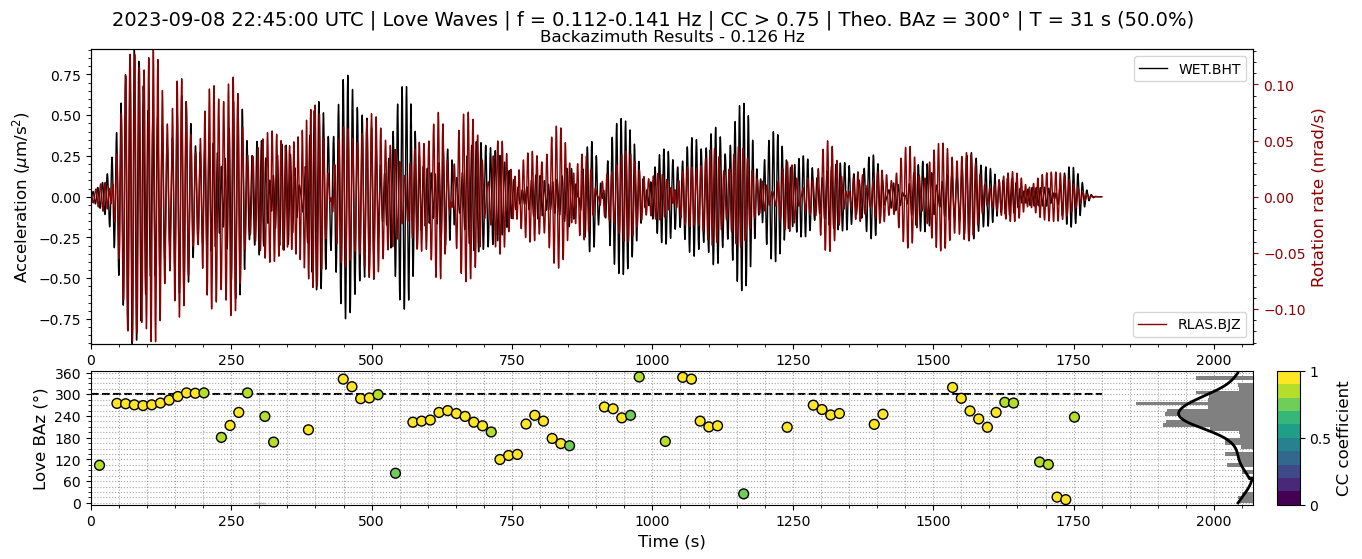

Error processing frequency band 0.126 Hz: Invalid method: theilsen. Use 'odr' or 'ransac'
  ✗ Failed

--- Processing frequency band 4/9: 0.158 Hz (0.141 - 0.178 Hz)---
baz_max = 248, baz_std = 72


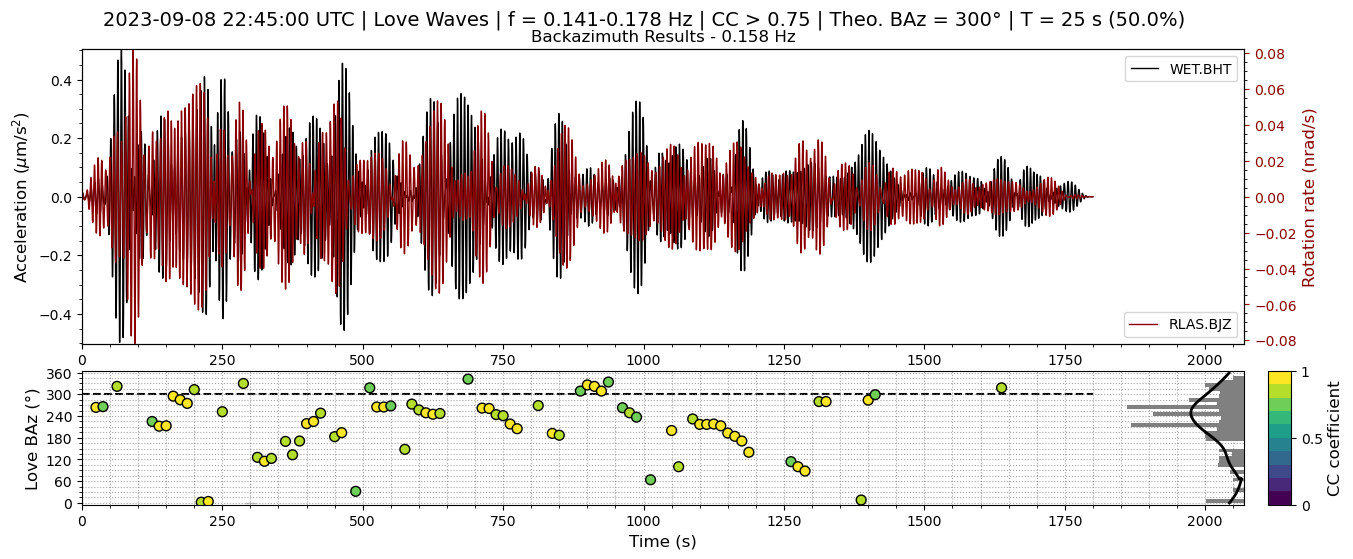

Error processing frequency band 0.158 Hz: Invalid method: theilsen. Use 'odr' or 'ransac'
  ✗ Failed

--- Processing frequency band 5/9: 0.200 Hz (0.178 - 0.224 Hz)---
baz_max = 220, baz_std = 78


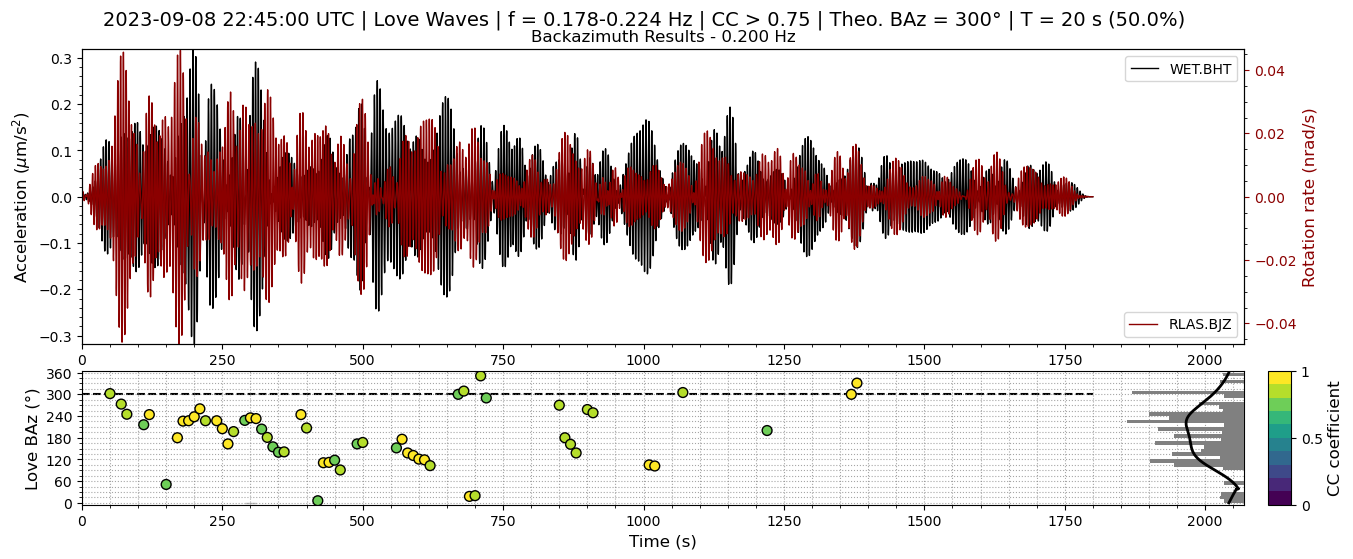

Error processing frequency band 0.200 Hz: Invalid method: theilsen. Use 'odr' or 'ransac'
  ✗ Failed

--- Processing frequency band 6/9: 0.251 Hz (0.224 - 0.282 Hz)---
baz_max = 252, baz_std = 68


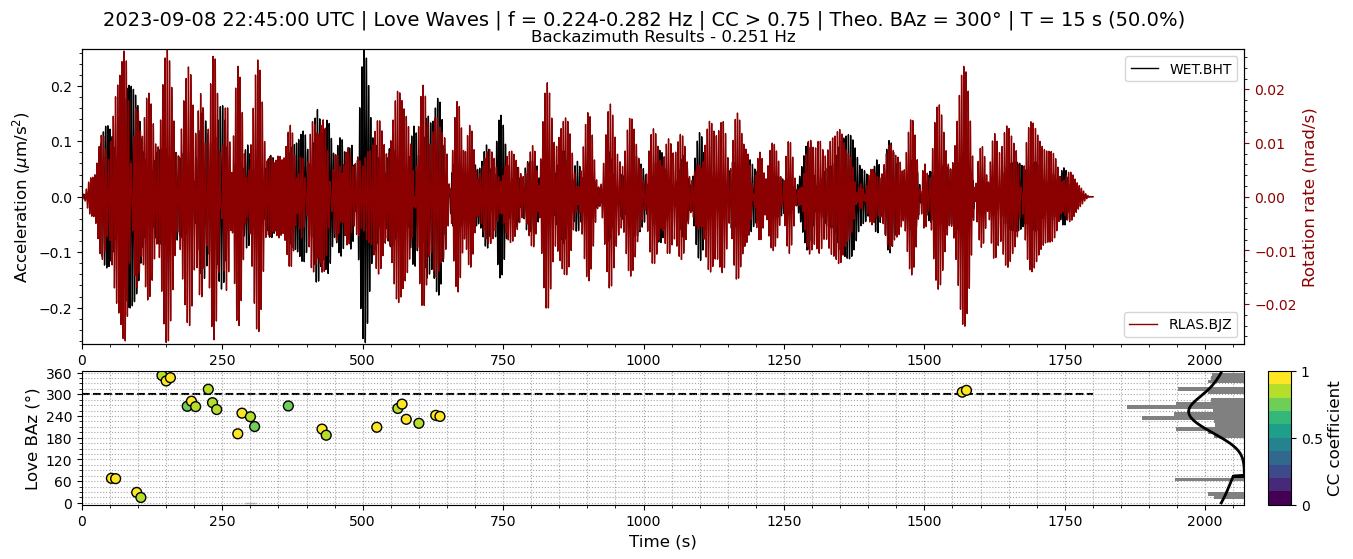

Error processing frequency band 0.251 Hz: Invalid method: theilsen. Use 'odr' or 'ransac'
  ✗ Failed

--- Processing frequency band 7/9: 0.316 Hz (0.282 - 0.355 Hz)---
baz_max = 291, baz_std = 50


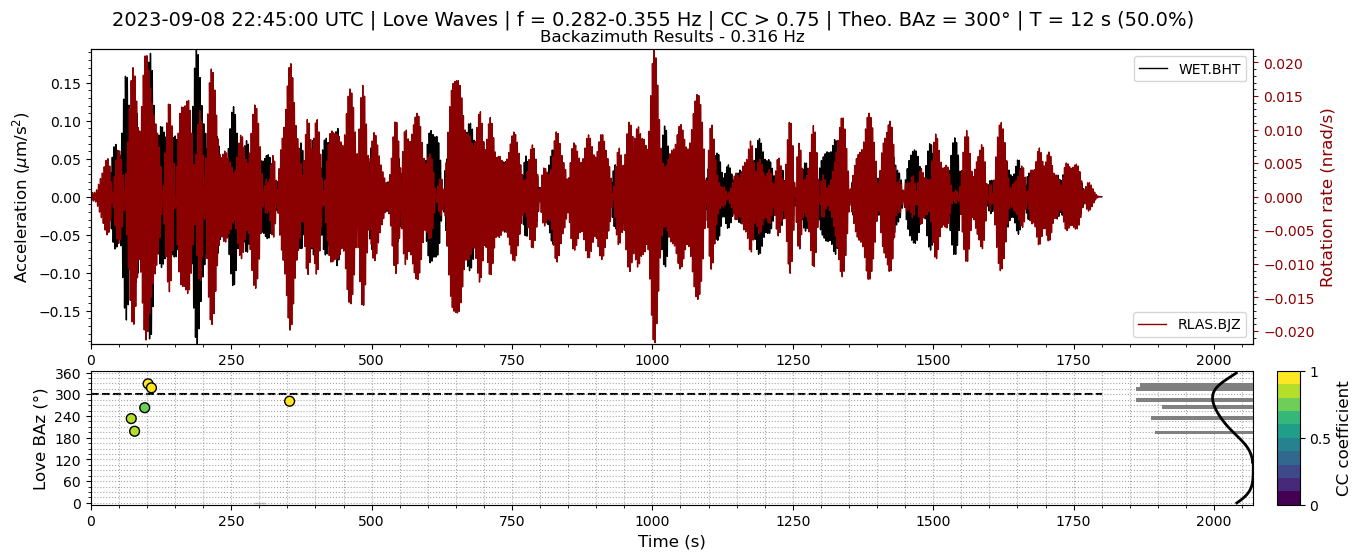

Error processing frequency band 0.316 Hz: Invalid method: theilsen. Use 'odr' or 'ransac'
  ✗ Failed

--- Processing frequency band 8/9: 0.398 Hz (0.355 - 0.447 Hz)---


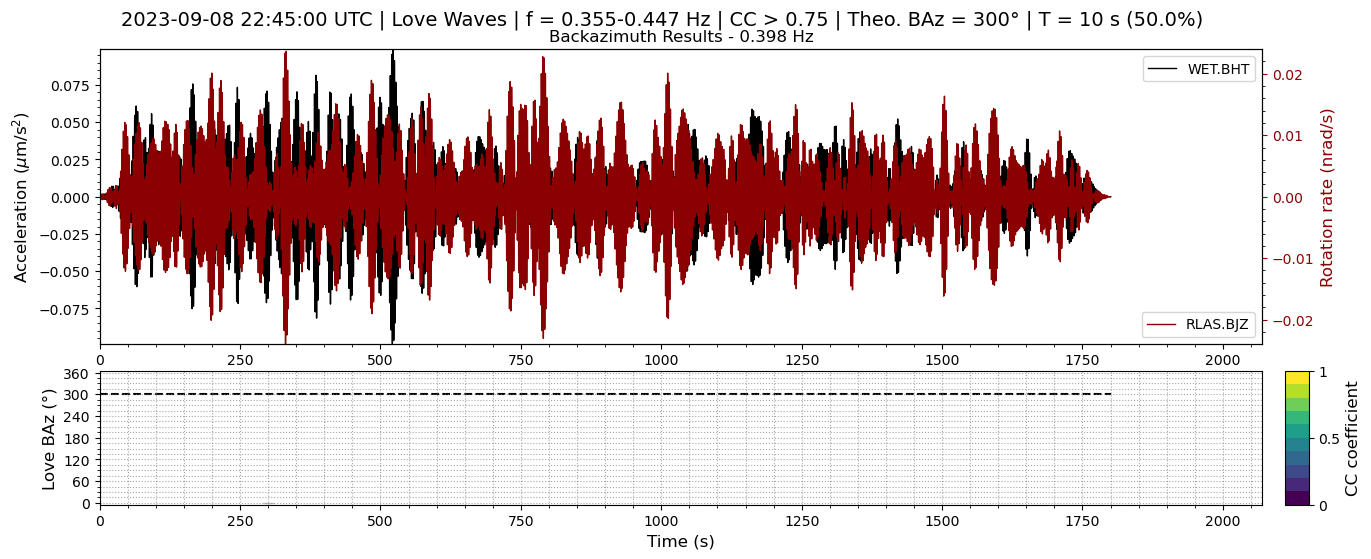

Error processing frequency band 0.398 Hz: Invalid method: theilsen. Use 'odr' or 'ransac'
  ✗ Failed

--- Processing frequency band 9/9: 0.501 Hz (0.447 - 0.562 Hz)---


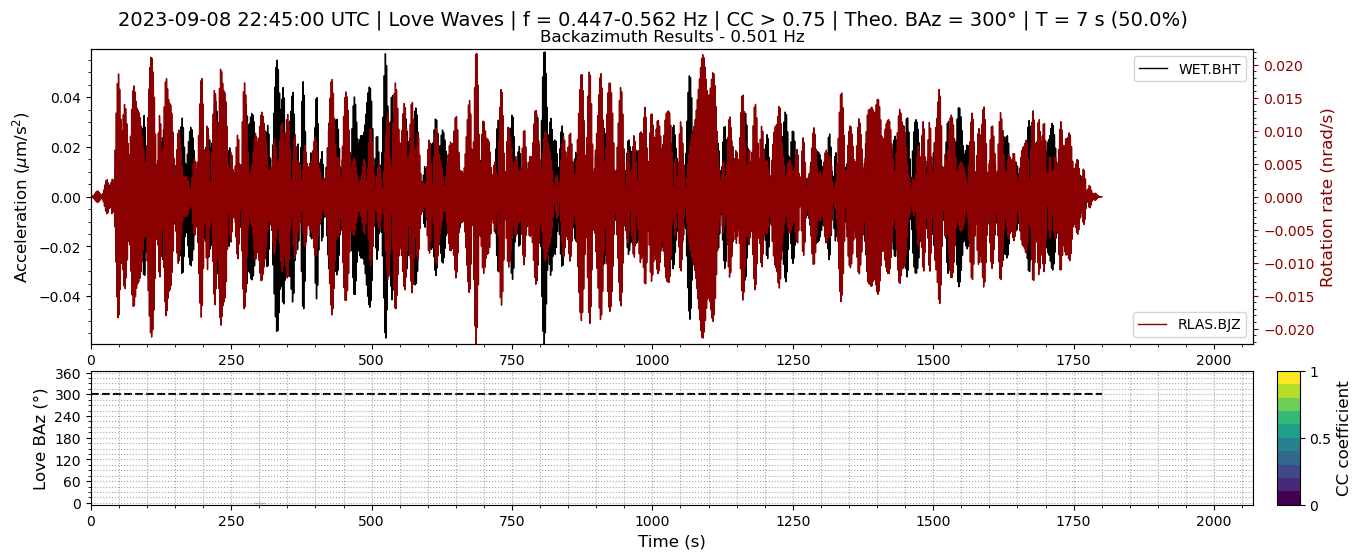

Error processing frequency band 0.501 Hz: Invalid method: theilsen. Use 'odr' or 'ransac'
  ✗ Failed

Processed 0 frequency bands successfully


In [ ]:
# Process each frequency band
hourly_results = []

for i, (fmin, fmax, fc) in enumerate(zip(flower, fupper, fcenter)):
    print(f"\n--- Processing frequency band {i+1}/{len(fcenter)}: {fc:.3f} Hz ({fmin:.3f} - {fmax:.3f} Hz)---")
    fmin, fmax, fc = round(fmin, 3), round(fmax, 3), round(fc, 3)

    result = process_frequency_band(
        sd_hour, config, fmin, fmax, fc, start_time, end_time
    )
    
    if result is not None:
        hourly_results.append(result)
        print(f"  ✓ Success: v={result['velocity']:.1f} m/s, n={result['n_measurements']}")
    else:
        print(f"  ✗ Failed")

print(f"\nProcessed {len(hourly_results)} frequency bands successfully")


## Results Analysis


In [ ]:
# Create results DataFrame
if hourly_results:
    results_df = pd.DataFrame(hourly_results)
    print("Results summary:")
    print(results_df[['fband', 'velocity', 'deviation', 'n_measurements']].round(2))
else:
    print("No results to display")


No results to display


In [ ]:
# Plot dispersion curve
if hourly_results:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Velocity vs frequency
    ax1.errorbar(results_df['fband'], results_df['velocity'], 
                yerr=results_df['deviation'], fmt='o-', capsize=5)
    ax1.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Velocity (m/s)')
    ax1.set_title('Dispersion Curve')
    ax1.grid(True, alpha=0.3)
    
    # Number of measurements vs frequency
    ax2.bar(results_df['fband'], results_df['n_measurements'], 
           width=0.01, alpha=0.7)
    ax2.set_xlabel('Frequency (Hz)')
    ax2.set_ylabel('Number of Measurements')
    ax2.set_title('Measurement Count')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
else:
    print("No data to plot")


No data to plot


## Detailed Analysis of Individual Frequency Bands


In [ ]:
# Analyze individual frequency band results
if hourly_results:
    for i, result in enumerate(hourly_results):
        print(f"\nFrequency Band {i+1}: {result['fband']:.3f} Hz")
        print(f"  Velocity: {result['velocity']:.1f} ± {result['deviation']:.1f} m/s")
        print(f"  Measurements: {result['n_measurements']}")
        
        if 'velocities' in result and len(result['velocities']) > 0:
            velocities = result['velocities']
            print(f"  Velocity range: {velocities.min():.1f} - {velocities.max():.1f} m/s")
            print(f"  Velocity median: {np.median(velocities):.1f} m/s")
            print(f"  Velocity std: {np.std(velocities):.1f} m/s")
